<a href="https://colab.research.google.com/github/kumarrajesh1992-arch/kumarrajesh1992-arch.github.io/blob/main/State_Capacity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I start by loading the core libraries I need for data handling, modelling and visual checks.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

print("Libraries loaded")

Libraries loaded


I import the state capacity dataset and check shape and head () to confirm file strcuture.

In [2]:
df = pd.read_csv("/content/State_Capacity_Analysis.csv")

print("Shape:", df.shape)
df.head()

Shape: (30, 5)


,State,residual_HDI,Edu_gov,Hea_gov,Per_Capita_Social_Exp
0,Andhra Pradesh,-0.032105,50.7,63.74,16449.409890
1,Arunachal Pradesh,0.004563,18.3,34.09,40275.277230
2,Assam,0.015827,62.8,49.64,11626.601600
3,Bihar,-0.006484,35.2,15.31,8212.896988
4,Chhattisgarh,-0.009414,57.5,42.27,13619.231680


I verify variable names and types using columns and info () and then scan for missingness with isna () .sum() to see which fields are incmploete.

In [3]:
df.columns

Index(['State', 'residual_HDI', 'Edu_gov', 'Hea_gov', 'Per_Capita_Social_Exp'], dtype='object')

I define the minimum required columns (State, residual_HDI, health_index, education_index) and explicitly check whether any are missing.

In [4]:
df.info()
df.isna().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   State                  30 non-null     object 
 1   residual_HDI           30 non-null     float64
 2   Edu_gov                30 non-null     float64
 3   Hea_gov                30 non-null     float64
 4   Per_Capita_Social_Exp  30 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.3+ KB


,0
State,0
residual_HDI,0
Edu_gov,0
Hea_gov,0
Per_Capita_Social_Exp,0


I define the minimum required columns (State, residual_HDI, health_index, education_index) and explicitly check whether any are missing.

In [5]:
needed = ["State", "residual_HDI", "health_index", "education_index"]
missing_cols = [c for c in needed if c not in df.columns]
missing_cols

['health_index', 'education_index']

In [6]:
# df = df.rename(columns={"HealthIndex":"health_index", "SEQI":"education_index"})

I drop incomplete rows for the required variables (dropna) to ensure the regression uses a comparable sample across predictors.

In [7]:
df_model = df.dropna(subset=[c for c in needed if c in df.columns]).copy()

df_model = df_model.rename(columns={"Edu_gov": "education_index", "Hea_gov": "health_index"})

print("Model shape after dropna:", df_model.shape)
df_model[needed].head()

Model shape after dropna: (30, 5)


,State,residual_HDI,health_index,education_index
0,Andhra Pradesh,-0.032105,63.74,50.7
1,Arunachal Pradesh,0.004563,34.09,18.3
2,Assam,0.015827,49.64,62.8
3,Bihar,-0.006484,15.31,35.2
4,Chhattisgarh,-0.009414,42.27,57.5


I define the regression design: X = [health_index, education_index] and y = residual_HDI, and I review summary statistics (describe) to confirm scales look plausible.

In [8]:
X = df_model[["health_index", "education_index"]]
y = df_model["residual_HDI"]

X.describe(), y.describe()

(       health_index  education_index
 count     30.000000        30.000000
 mean      46.837333        48.146667
 std       14.655031        13.715527
 min       15.310000        18.300000
 25%       36.190000        38.400000
 50%       49.875000        47.200000
 75%       57.825000        57.225000
 max       71.060000        79.000000,
 count    30.000000
 mean      0.000508
 std       0.020046
 min      -0.035715
 25%      -0.011551
 50%       0.002450
 75%       0.012792
 max       0.050576
 Name: residual_HDI, dtype: float64)

I z-score both capacity measures using StandardScaler() to make coefficients directly comparable (standardised betas).

In [9]:
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

Xz = pd.DataFrame(Xz, columns=["health_index_z", "education_index_z"])
Xz.describe()

,health_index_z,education_index_z
count,3.000000e+01,3.000000e+01
mean,4.958996e-16,-1.332268e-16
std,1.017095e+00,1.017095e+00
min,-2.188075e+00,-2.213324e+00
25%,-7.389512e-01,-7.227785e-01
50%,2.108215e-01,-7.020147e-02
75%,7.625711e-01,6.732173e-01
max,1.681113e+00,2.287975e+00


I estimate the combined linear model (LinearRegression) and report (i) standardised coefficients for both indices and (ii) the model’s R² as a compact measure of explanatory power.

In [10]:
model = LinearRegression()
model.fit(Xz, y)

coefs = pd.Series(model.coef_, index=Xz.columns)
r2 = model.score(Xz, y)

print("Standardised betas:")
print(coefs)
print("\nR²:", r2)

Standardised betas:
health_index_z      -0.006823
education_index_z    0.001369
dtype: float64

R²: 0.09868140050192742


I compute fitted values and errors: predicted residual HDI (residual_HDI_pred_cap) and the model error (cap_model_error = actual − predicted).

In [11]:
df_model["residual_HDI_pred_cap"] = model.predict(Xz)
df_model["cap_model_error"] = df_model["residual_HDI"] - df_model["residual_HDI_pred_cap"]

df_model[["State", "residual_HDI", "residual_HDI_pred_cap", "cap_model_error"]].head()

,State,residual_HDI,residual_HDI_pred_cap,cap_model_error
0,Andhra Pradesh,-0.032105,-0.007237,-0.024868
1,Arunachal Pradesh,0.004563,0.003514,0.001049
2,Assam,0.015827,0.000669,0.015158
3,Bihar,-0.006484,0.014123,-0.020607
4,Chhattisgarh,-0.009414,0.003621,-0.013035


I run two diagnostic scatter plots (Residual HDI vs Health Index; Residual HDI vs Education Index) with a zero reference line to visually check whether any relationship is visible.

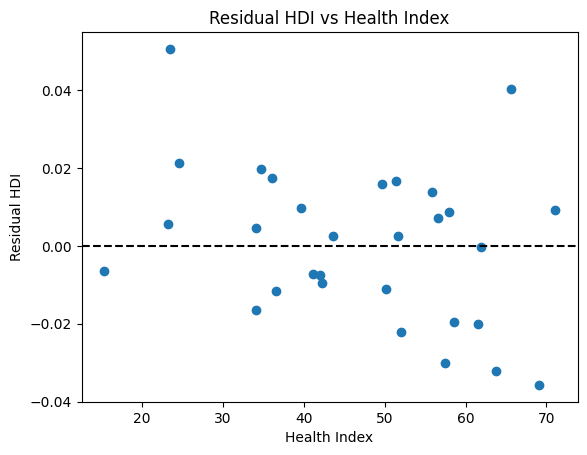

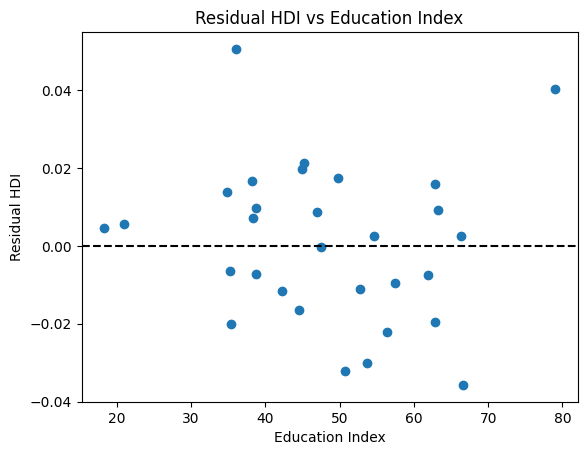

In [12]:
plt.scatter(df_model["health_index"], df_model["residual_HDI"])
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Health Index")
plt.ylabel("Residual HDI")
plt.title("Residual HDI vs Health Index")
plt.show()

plt.scatter(df_model["education_index"], df_model["residual_HDI"])
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Education Index")
plt.ylabel("Residual HDI")
plt.title("Residual HDI vs Education Index")
plt.show()

I export the final state-level table (including predictors, predicted values, and errors) to CSV for Vega-Lite visualisation and reporting.

In [13]:
out = df_model[[
    "State",
    "residual_HDI",
    "health_index",
    "education_index",
    "residual_HDI_pred_cap",
    "cap_model_error"
]].copy()

out.to_csv("/content/CC10_Block2_Capacity_Explains_Residuals.csv", index=False)
print("Exported CC10_Block2_Capacity_Explains_Residuals.csv")

Exported CC10_Block2_Capacity_Explains_Residuals.csv


I compute the correlation between the two capacity indicators to check whether they move together strongly (a simple multicollinearity signal).

In [14]:
df_model[["health_index", "education_index"]].corr()

,health_index,education_index
health_index,1.000000,0.540339
education_index,0.540339,1.000000
